In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\choiseongjun\\AppData\\Local\\Temp\\pip-uninstall-ctca0h15\\pip.exe'
Consider using the `--user` option or check the permissions.




  Using cached pip-21.0.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.0
    Uninstalling pip-21.0:
      Successfully uninstalled pip-21.0


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16131007962155652402
]


In [8]:
DEFAULT_IMAGE_SIZE = tuple((224, 224))

# Path to the dataset folder
root_dir = './PlantVillage'
# path -> ./PlantVilaage/train and ./PlantVillage/val
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'valid')

Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is NOT AVAILABLE


In [45]:
#count training data and validation data
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

path = "C:/Users/choiseongjun/Desktop/KHU/CampusActivities/OverseasStudy/PlantTeacher_ImageProcessing/"
saved_train_dir = path + "PlantVillage/train/"
saved_valid_dir = path + "PlantVillage/valid/"

print('total images for training :', count(saved_train_dir))
print('total images for validation :', count(saved_valid_dir))

total images for training : C:/Users/choiseongjun/Desktop/KHU/CampusActivities/OverseasStudy/PlantTeacher_ImageProcessing/PlantVillage/train/ : 48265files
total images for validation : C:/Users/choiseongjun/Desktop/KHU/CampusActivities/OverseasStudy/PlantTeacher_ImageProcessing/PlantVillage/valid/ : 12040files


In [46]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [48]:
IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

In [49]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

path = "C:/Users/choiseongjun/Desktop/KHU/CampusActivities/OverseasStudy/PlantTeacher_ImageProcessing/"
saved_train_dir = path + "PlantVillage/train/"
saved_valid_dir = path + "PlantVillage/valid/"

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    saved_valid_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    saved_train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 12040 images belonging to 38 classes.
Found 48265 images belonging to 38 classes.


In [50]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
'''
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5", output_shape=[1280], trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
try this code it improves accuracy from 90% to 95%, and consumption of time as well.
'''


In [51]:
#Compile model specifying the optimizer learning rate
#categorical_crossentropy is used for many categories. I.e. we have tomatoes and pepper
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [52]:
EPOCHS=15 #@param {type:"integer"}

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
754/754 [==============================] - 1564s 2s/step - loss: 1.1308 - accuracy: 0.6806 - val_loss: 0.2932 - val_accuracy: 0.9066
Epoch 2/15
754/754 [==============================] - 1551s 2s/step - loss: 0.4288 - accuracy: 0.8600 - val_loss: 0.2601 - val_accuracy: 0.9141
Epoch 3/15
754/754 [==============================] - 1559s 2s/step - loss: 0.3794 - accuracy: 0.8745 - val_loss: 0.2154 - val_accuracy: 0.9309
Epoch 4/15
754/754 [==============================] - 1415s 2s/step - loss: 0.3460 - accuracy: 0.8847 - val_loss: 0.2324 - val_accuracy: 0.9229
Epoch 5/15
754/754 [==============================] - 1413s 2s/step - loss: 0.3415 - accuracy: 0.8885 - val_loss: 0.1950 - val_accuracy: 0.9355
Epoch 6/15
754/754 [==============================] - 1511s 2s/step - loss: 0.3282 - accuracy: 0.8924 - val_loss: 0.1867 - val_accuracy: 0.9419
Epoch 7/15
754/754 [==============================] - 1382s 2s/step - loss: 0.3120 - accuracy: 0.8963 - val_loss: 0.1918 - val_accuracy:

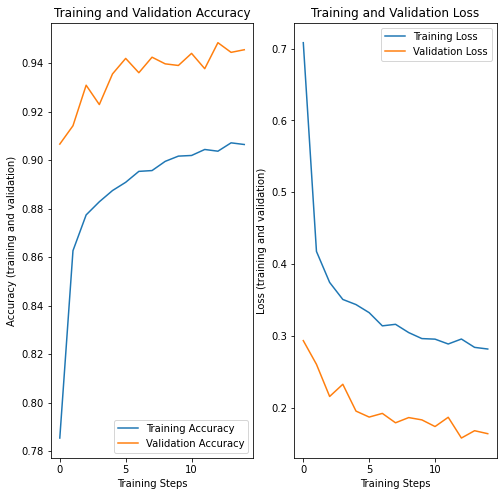

In [58]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [63]:
!pip install opencv-python

# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob

data_dir = "C:/Users/choiseongjun/Desktop/KHU/CampusActivities/OverseasStudy/PlantTeacher_ImageProcessing/PlantVillage"
validation_dir = "valid"

def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Soybean___healthy, file: Soybean___healthy\image (4983).JPG
PREDICTED: class: Soybean___healthy, confidence: 0.998962


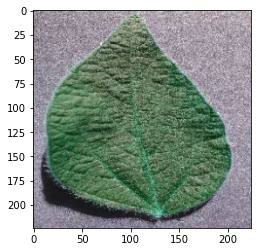

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___healthy, file: Tomato___healthy\image (945).JPG
PREDICTED: class: Tomato___Target_Spot, confidence: 0.812145


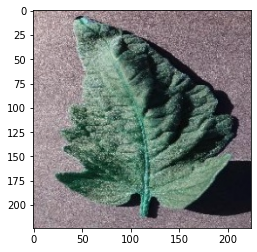

SOURCE: class: Peach___Bacterial_spot, file: Peach___Bacterial_spot\image (1160).JPG
PREDICTED: class: Peach___Bacterial_spot, confidence: 0.999888


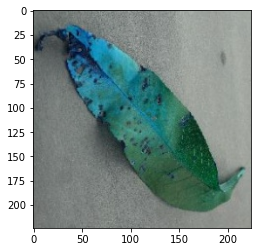

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus\image (48).JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.483625


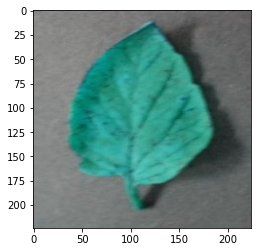

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, file: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\image (956).JPG
PREDICTED: class: Pepper,_bell___Bacterial_spot, confidence: 0.454581


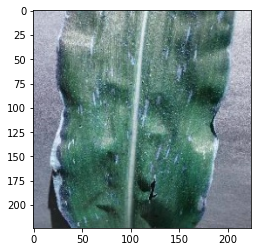

<Figure size 432x288 with 0 Axes>

In [66]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [70]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
# tf.keras.experimental.export_saved_model(model, export_path)
model.save(export_path)

INFO:tensorflow:Assets written to: /tmp/saved_models/1613383587\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1613383587\assets


'/tmp/saved_models/1613383587'

In [72]:
# Now confirm that we can reload it, and it still gives the same results
# reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [73]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Cherry_(including_sour)___healthy, file: Cherry_(including_sour)___healthy\image (342).JPG
PREDICTED: class: Cherry_(including_sour)___healthy, confidence: 0.999961


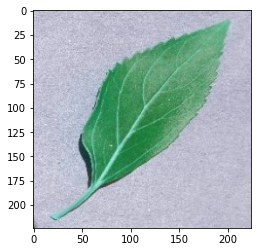

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Target_Spot, file: Tomato___Target_Spot\image (823).JPG
PREDICTED: class: Tomato___Target_Spot, confidence: 0.934785


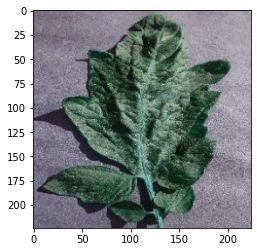

In [74]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    try:
        img = load_image(filename)
        prediction = predict_reload(img)
        print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
        plt.imshow(img)
        plt.figure(idx)    
        plt.show()
    except Exception as e:
        print(e)

In [75]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11629184